

*   Ayman Haque
*   HW: 05
*   Deep Learning
*   Fall 2020









In [ ]:
#---------------------- import libraries ------------------------
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import backend as K




In [ ]:
"""Functions: RGB to GRAY"""
# grayscale = 0.299*red + 0.587*green + 0.114*blue

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [ ]:
"""Dataset  loading and preprocessing"""

# load the CIFAR10 data
(x_train, _), (x_test, _) = cifar10.load_data()
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
channels = x_train.shape[3] 

print(x_train.shape)

(50000, 32, 32, 3)


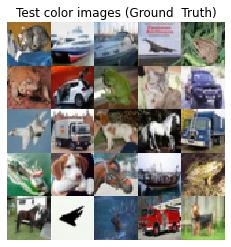

(160, 160, 3)

In [ ]:
# display the 1st 25 input images 
imgs = x_test[:25]
imgs = imgs.reshape((5, 5, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test color images (Ground  Truth)')
plt.imshow(imgs, interpolation='none')
plt.show()


In [ ]:
"""Introducing noise to images """

# add Noise to color images
# generate corrupted CIFAT10 images by adding noise with normal dist
# centered at 0.5 and std=0.5
np.random.seed(1247)

noise         = np.random.normal(loc=0.0, scale=0.2, size=x_train.shape)
x_train_noisy = x_train + noise
noise         = np.random.normal(loc=0.0, scale=0.2, size=x_test.shape)
x_test_noisy  = x_test + noise

# adding noise may exceed normalized pixel values>1.0 or <0.0
# clip pixel values >1.0 to 1.0 and <0.0 to 0.0
x_train_noisy = np.ndarray.clip(x_train_noisy, 0., 1.)
x_test_noisy  = np.ndarray.clip(x_test_noisy, 0.,1.)

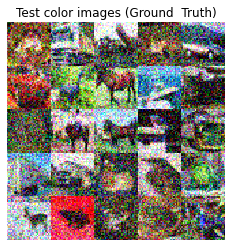

In [ ]:
"""Displaying Noisy Images"""

imgs = x_train_noisy[:25]
imgs = imgs.reshape((5, 5, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test color images (Ground  Truth)')
plt.imshow(imgs, interpolation='none')
plt.show()

In [ ]:
"""Converting both noisy and uncorrupted image to greyscale """

x_train_gray_original = rgb2gray(x_train)
x_test_gray_original = rgb2gray(x_test)
x_train_gray_noisy = rgb2gray(x_train_noisy)
x_test_gray_noisy = rgb2gray(x_test_noisy)


"""Reshaping the greyscale images"""

x_train_gray_original    = np.reshape(x_train_gray_original, [-1, img_rows, img_cols, 1])
x_test_gray_original     = np.reshape(x_test_gray_original, [-1, img_rows, img_cols, 1])
x_train_gray_noisy    = np.reshape(x_train_gray_noisy, [-1, img_rows, img_cols, 1])
x_test_gray_noisy     = np.reshape(x_test_gray_noisy, [-1, img_rows, img_cols, 1])


# print(x_train_gray_original.shape)
# print(x_test_gray_original.shape)
# print(x_train_gray_noisy.shape)
# print(x_test_gray_noisy.shape)


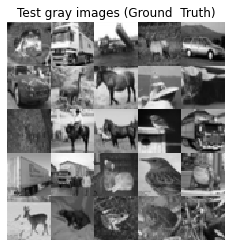

In [ ]:
"""Displaying Original images converted to greyscale """

imgs = x_train_gray_original[:25]
imgs = imgs.reshape((5, 5, img_rows, img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test gray images (Ground  Truth)')
plt.imshow(imgs, interpolation='none',cmap="gray")
plt.show()




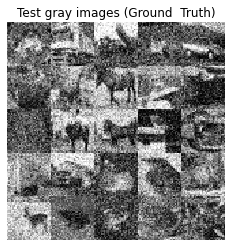

In [ ]:

"""Displaying corrupted images converted to greyscale """
imgs = x_train_gray_noisy[:25]
imgs = imgs.reshape((5, 5, img_rows, img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test gray images (Ground  Truth)')
plt.imshow(imgs, interpolation='none',cmap="gray")
plt.show()

In [ ]:
"""Encoder Model """


# network parameters
input_shape = (img_rows, img_cols, 1)
batch_size  = 32
kernel_size = 3
latent_dim  = 40

# encoder/decoder number of CNN layers and filters per layer
layer_filters = [64, 128]

# Build the autoencoder model

# first build the encoder model

inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=2, activation='relu', padding='same')(x)


shape = K.int_shape(x)

# generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model
encoder = Model(inputs, latent, name='Encoder')
encoder.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)        640       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 40)                327720    
Total params: 402,216
Trainable params: 402,216
Non-trainable params: 0
_________________________________________________________________


In [ ]:

"""The Decoder model"""


# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')

x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# stack of Conv2DTranspose(64)-Conv2DTranspose(32)

for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=2, activation='relu', padding='same')(x)

# reconstruct the denoised input
outputs = Conv2DTranspose(filters=1, kernel_size=kernel_size, padding='same', activation='sigmoid', name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# autoencoder = encoder + decoder

# instantiate autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 40)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 8192)              335872    
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 16, 16, 128)       147584    
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 32, 32, 64)        73792     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 32, 32, 1)         577       
Total params: 557,825
Trainable params: 557,825
Non-trainable params: 0
_____________________________________________________

In [ ]:

# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')

# train the autoencoder
autoencoder.fit(x_train_gray_noisy, x_train_gray_original, validation_data=(x_test_gray_noisy, x_test_gray_original),
                epochs=10, batch_size=batch_size)
# predict the autoencoder output from corrupted test images

x_decoded = autoencoder.predict(x_test_gray_noisy)

Epoch 1/10
1563/1563 [==============================] - 319s 204ms/step - loss: 0.0122 - val_loss: 0.0092
Epoch 2/10
1563/1563 [==============================] - 321s 205ms/step - loss: 0.0091 - val_loss: 0.0090
Epoch 3/10
1563/1563 [==============================] - 321s 206ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 4/10
1563/1563 [==============================] - 327s 209ms/step - loss: 0.0088 - val_loss: 0.0088
Epoch 5/10
1563/1563 [==============================] - 325s 208ms/step - loss: 0.0087 - val_loss: 0.0088
Epoch 6/10
1563/1563 [==============================] - 326s 208ms/step - loss: 0.0086 - val_loss: 0.0087
Epoch 7/10
1563/1563 [==============================] - 328s 210ms/step - loss: 0.0085 - val_loss: 0.0087
Epoch 8/10
1563/1563 [==============================] - 328s 210ms/step - loss: 0.0084 - val_loss: 0.0088
Epoch 9/10
1563/1563 [==============================] - 326s 208ms/step - loss: 0.0084 - val_loss: 0.0087
Epoch 10/10
1563/1563 [=======================

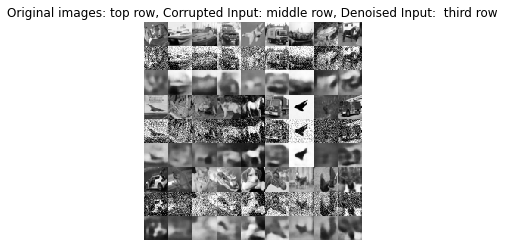

In [ ]:
""" Displaying the Original images, corrupted images and denoised output in stacks"""

rows, cols = 3, 9
num = rows * cols
imgs = np.concatenate([x_test_gray_original[:num], x_test_gray_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, img_rows, img_cols))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, img_rows, img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.figure()
plt.axis('off')
plt.title('Original images: top row, '
          'Corrupted Input: middle row, '
          'Denoised Input:  third row')
plt.imshow(imgs, interpolation='none', cmap='gray')

plt.show()

In [ ]:
Image.fromarray(imgs).save('originadenoised.png')